# Compare the Saliencies of ProteinGym 166 to those of PLA2 

Idea: See whether the dimensions with the highest saliencies are somewhat similar between these two datasets

In [40]:
import numpy as np 
import pandas as pd
import os 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import pearsonr, spearmanr

In [1]:
wildtype_dimension = 0
mutant_dimension = 1
embeddings_dimension = 2

In [7]:
def load_mean_saliencies(saliency_folder):
    mean_saliencies = np.zeros((2560,))
    sem_saliences = np.zeros((2560,))
    files = [file for file in os.listdir(saliency_folder) if file.endswith('.npy')]

    # load each numpy object in the saliency folder
    for file in tqdm(files, unit='file', desc=f'Loading saliencies from {saliency_folder}'):
        id = file.split('.npy')[0]
        saliency = np.load(os.path.join(saliency_folder, file))
        
        # take the absolute values of the saliencies
        saliency = np.abs(saliency)
        
        # reduce the saliency to the average per embedding dimension 
        mean_saliency_per_dim = saliency.mean(axis=(wildtype_dimension, mutant_dimension)) # (2560,)

        # calculate the sem of the saliency
        sem_saliency_per_dim = np.std(saliency, axis=(wildtype_dimension, mutant_dimension)) / np.sqrt(saliency.shape[wildtype_dimension] * saliency.shape[mutant_dimension])
        
        # add to the mean and sem saliencies
        mean_saliencies += mean_saliency_per_dim
        sem_saliences += sem_saliency_per_dim
    
    # average the saliencies
    mean_saliencies /= len(files)
    sem_saliences /= len(files)

    return mean_saliencies, sem_saliences 

In [8]:
# load proteingym166 saliencies
saliency_folder = '/mnt/f/nicole/proteingym_166_saliency/'
proteingym_mean_saliencies, proteingym_sem_saliencies = load_mean_saliencies(saliency_folder)

# load pla2 saliencies
saliency_folder = '/mnt/f/nicole/pla2_saliency/'
pla2_mean_saliencies, pla2_sem_saliencies = load_mean_saliencies(saliency_folder)

Loading saliencies from /mnt/f/nicole/proteingym_166_saliency/: 100%|██████████| 166/166 [13:21<00:00,  4.83s/file]
Loading saliencies from /mnt/f/nicole/pla2_saliency/: 100%|██████████| 524/524 [19:33<00:00,  2.24s/file]


In [24]:
pearson_correlation = pearsonr(proteingym_mean_saliencies, pla2_mean_saliencies)
spearman_correlation = spearmanr(proteingym_mean_saliencies, pla2_mean_saliencies)
print(f'Pearson correlation: {pearson_correlation}')
print(f'Spearman correlation: {spearman_correlation}')

Pearson correlation: PearsonRResult(statistic=0.8106068011607436, pvalue=0.0)
Spearman correlation: SignificanceResult(statistic=0.7519580078728496, pvalue=0.0)


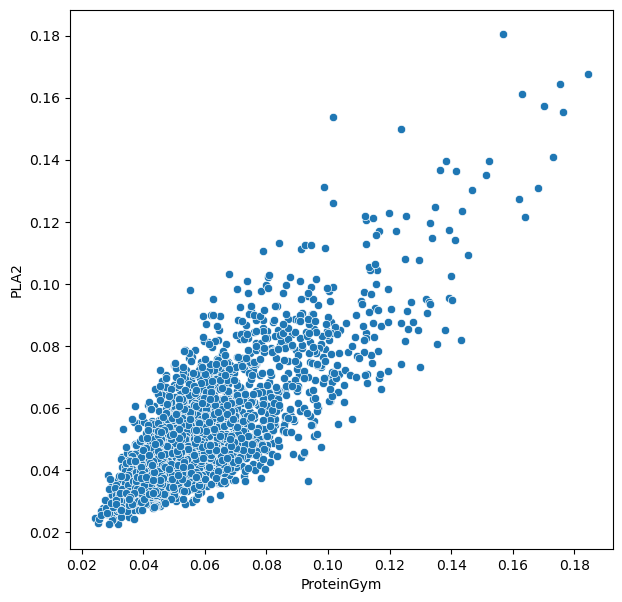

In [23]:
# plot the proteingym and pla2 saliencies against each other to check for linearity 
plt.figure(figsize=(7,7))
sns.scatterplot(x=proteingym_mean_saliencies, y=pla2_mean_saliencies)
plt.xlabel('ProteinGym')
plt.ylabel('PLA2')
plt.show()

There is definetly a correlation between the saliencies of PLA2 and ProteinGym 166

In [29]:
percentiles = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
percentile_values_proteingym = np.percentile(proteingym_mean_saliencies, percentiles)
percentile_values_pla2 = np.percentile(pla2_mean_saliencies, percentiles)

In [30]:
def create_bins(percentile_values, mean_saliencies):
    bins = {}
    for i in range(len(percentile_values) - 1):
        lower_bound = percentile_values[i]
        upper_bound = percentile_values[i+1]
        indices = np.where((mean_saliencies >= lower_bound) & (mean_saliencies < upper_bound))[0]
        bins[f"{percentiles[i]}-{percentiles[i+1]}"] = indices
    # last bin 
    indices = np.where(mean_saliencies >= percentile_values[-1])[0]
    bins[f"{percentiles[-1]}-100"] = indices
    return bins

In [32]:
# create buckets with the dimensions based on their quantile distribution 
proteingym_bins = create_bins(percentile_values_proteingym, proteingym_mean_saliencies)
pla2_bins = create_bins(percentile_values_pla2, pla2_mean_saliencies)

In [ ]:
# create the reversed dictionary
proteingym_bins_reverted = {}
pla2_bins_reverted = {}

for bin_name in proteingym_bins.keys():
    for idx in proteingym_bins[bin_name]:
        proteingym_bins_reverted[idx] = bin_name
    for idx in pla2_bins[bin_name]:
        pla2_bins_reverted[idx] = bin_name

proteingym_clusters = pd.DataFrame(proteingym_bins_reverted.items(), columns=['dimension', 'proteingym_cluster'])
pla2_clusters = pd.DataFrame(pla2_bins_reverted.items(), columns=['dimension', 'pla2_cluster'])
clusters = proteingym_clusters.merge(pla2_clusters, on='dimension')
clusters.head()


,dimension,proteingym_cluster,pla2_cluster
0,18,0-5,0-5
1,73,0-5,5-10
2,90,0-5,5-10
3,94,0-5,5-10
4,122,0-5,0-5


In [46]:
# use rand score to calculate cluster similarity
from sklearn.metrics import rand_score
rand_score(clusters['proteingym_cluster'], clusters['pla2_cluster'])

0.9114729874951153